# Customer Segmentation using Clustering
***
This project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. 

In [1]:
#imports
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#Seaborn setup
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

First, we shall merge two data frames:

In [4]:
df = pd.merge(df_offers, df_transactions)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [5]:
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


Replacing NaNs with zeros and reseting the index:

In [6]:
matrix = matrix.fillna(0).reset_index()
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
x_cols = matrix.columns[1:]
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

## K-Means Clustering

In K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will use two methods: the Elbow method and the Silhouette method.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

In [8]:
from sklearn.cluster import KMeans
sse = {}
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(matrix[matrix.columns[2:]])
    sse[k] = kmeans.inertia_

Here we have computed Sum-of-Squares for KMeans Clustering models by varying the number of clusters from 2 to 10.

We shall plot the graph between number of clusters and sum of squares to find the elbow point.

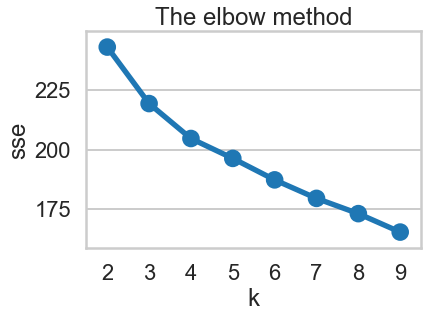

In [9]:
plt.title("The elbow method")
plt.xlabel('k')
plt.ylabel('sse')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Choosing K: The Silhouette Method

The Silhouette Method measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>


In [13]:
from sklearn.metrics import silhouette_score
selscore = {}
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(matrix[matrix.columns[2:]])
    selscore[k] = silhouette_score(matrix[matrix.columns[2:]], cluster_labels)

Here we have computed silhouette_score for KMeans Clustering models by varying the number of clusters from 2 to 10.

We shall plot the graph between number of clusters and silhouette_score to find the optimum number of clusters.

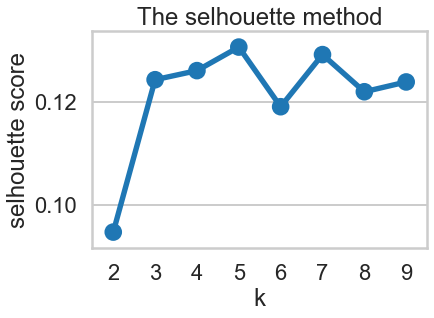

In [14]:
plt.title("The selhouette method")
plt.xlabel('k')
plt.ylabel('selhouette score')
sns.pointplot(x=list(selscore.keys()), y=list(selscore.values()))
plt.show()

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. Here, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

First, we are fitting a KMeans clustering model on the data points with n_clusters = 5(which we got from the elbow method).

In [15]:
cluster = KMeans(n_clusters=5)
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])
matrix.cluster.value_counts()

0    40
1    19
3    15
2    14
4    12
Name: cluster, dtype: int64

Using scikit-learn's PCA we are reducing the dimensionality of clustering data to 2 components.

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()
matrix.head()

offer_id,index,customer_name,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,cluster,x,y
0,0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,1.007580,0.108215
1,1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,-0.287539,0.044715
2,2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,-0.392032,1.038391
3,3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,0.699477,-0.022542
4,4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,0.088183,-0.471695


Here, we are creating a data frame from the above data.

In [17]:
customer_clusters = matrix[['customer_name', 'cluster', 'x','y']]
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,1,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,3,-0.392032,1.038391
3,Bailey,4,0.699477,-0.022542
4,Baker,4,0.088183,-0.471695


Finnaly we are fitting a scatter plot of the principal components and visualizing the clusters by color coding.

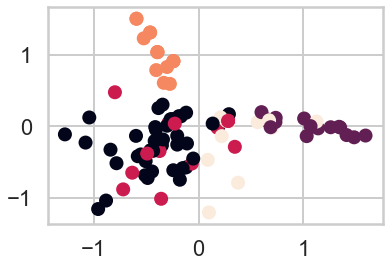

In [18]:
plt.scatter(matrix['x'], matrix['y'], c=matrix['cluster'])
plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?

This can be found out by explained_variance_ of PCA object. It is same as elbow method we looked earlier. Here, we have to find the point where the curve's rate of descent seems to slow sharply.

In [19]:
pca1 = PCA()
pca1.fit(matrix[matrix.columns[4:36]])
pca1.transform(matrix[matrix.columns[4:36]])
pca1.explained_variance_

array([2.26114914e+00, 7.72069663e-01, 2.73343719e-01, 1.57921134e-01,
       1.51490365e-01, 1.47206238e-01, 1.35576328e-01, 1.19116885e-01,
       1.12424242e-01, 1.00559583e-01, 9.63960170e-02, 8.65401444e-02,
       8.36214399e-02, 6.79025875e-02, 6.37477940e-02, 6.07847767e-02,
       5.49158682e-02, 5.11991664e-02, 4.44571458e-02, 4.28344760e-02,
       3.74700871e-02, 3.66305615e-02, 3.47136673e-02, 3.07115236e-02,
       2.78909141e-02, 2.50556048e-02, 2.09705827e-02, 1.88361008e-02,
       1.68038700e-02, 1.43311605e-02, 7.83027167e-03, 1.61249291e-03])

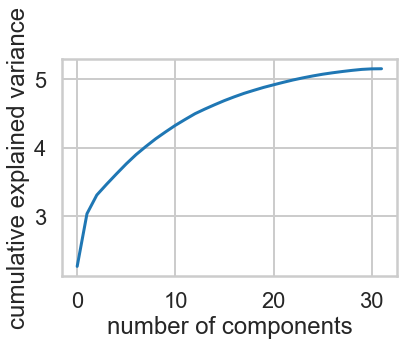

In [21]:
plt.plot(np.cumsum(pca1.explained_variance_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

From the graph we can see that, 10 components would be enough for clustering.

<div class="span5 alert alert-info">
<h3>We shall try to cluster by some other clustering algorithms</h3>
</div>


## Other Clustering Algorithms

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

In [22]:
from sklearn.cluster import AffinityPropagation
affinity = AffinityPropagation(random_state=5)
matrix['affinity_cluster'] = affinity.fit_predict(matrix[matrix.columns[2:34]])
matrix.affinity_cluster.value_counts()

12    11
10    11
8     10
6     10
3     10
13     8
0      8
4      7
2      6
11     5
7      5
9      3
5      3
1      3
Name: affinity_cluster, dtype: int64

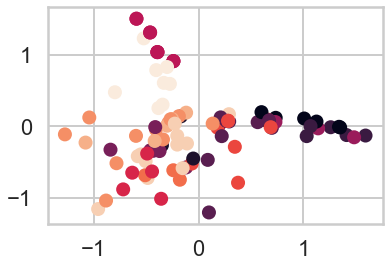

In [24]:
plt.scatter(matrix['x'], matrix['y'], c=matrix['affinity_cluster'])
plt.show()

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

In [25]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=5)
matrix['spectral_cluster'] = spectral.fit_predict(matrix[matrix.columns[2:34]])
matrix.spectral_cluster.value_counts()

2    47
0    20
4    14
1    14
3     5
Name: spectral_cluster, dtype: int64

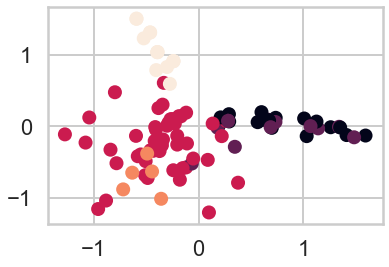

In [26]:
plt.scatter(matrix['x'], matrix['y'], c=matrix['spectral_cluster'])
plt.show()

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

In [27]:
from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_clusters=5)
matrix['agg_cluster'] = agglomerative.fit_predict(matrix[matrix.columns[2:34]])
matrix.agg_cluster.value_counts()

4    34
1    30
2    17
0    11
3     8
Name: agg_cluster, dtype: int64

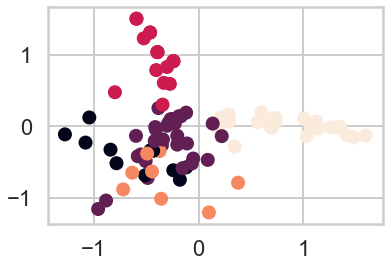

In [28]:
plt.scatter(matrix['x'], matrix['y'], c=matrix['agg_cluster'])
plt.show()

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

In [29]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1.3, min_samples=5)
matrix['db_cluster'] = dbscan.fit_predict(matrix[matrix.columns[2:34]])
matrix.db_cluster.value_counts()

-1    60
 2    16
 1    14
 0     7
 3     3
Name: db_cluster, dtype: int64

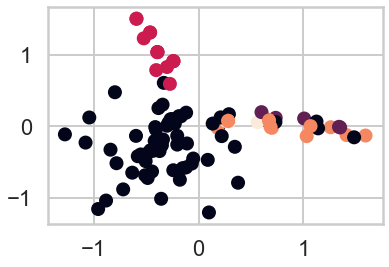

In [30]:
plt.scatter(matrix['x'], matrix['y'], c=matrix['db_cluster'])
plt.show()

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html